# Validate parquet files

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.utils import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/27 20:05:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/02/27 20:05:28 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
# Get list of stored filed in cloud bucket
root = "gs://dsgt-clef-plantclef-2024"
! date
! gcloud storage ls {root}/data/parquet_files

Tue Feb 27 20:05:32 UTC 2024
gs://dsgt-clef-plantclef-2024/data/parquet_files/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2022_web_training_images_1/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2022_web_training_images_4/


In [4]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-plantclef-2024/data/parquet_files/"
train_1 = "PlantCLEF2022_web_training_images_1"
train_4 = "PlantCLEF2022_web_training_images_4"

# Define the GCS path to the Train parquet file
train1_gcs_path = f"{gcs_path}{train_1}"
train4_gcs_path = f"{gcs_path}{train_4}"


# Read the Parquet file into a DataFrame
train1_df = spark.read.parquet(train1_gcs_path)
train4_df = spark.read.parquet(train4_gcs_path)

# Show the data (for example, first few rows)
train1_df.show(n=3)

+--------------------+--------------------+--------------------+--------+--------------------+--------------------+---------+----------+---------+-------------+----------+-------------+-------------------------+--------------------+--------------------+
|          image_path|                path|                data| classid|          image_name|             species|    genus|    family|    order|        class|manual_tag|predicted_tag|predicted_tag_probability|        original_url|    image_backup_url|
+--------------------+--------------------+--------------------+--------+--------------------+--------------------+---------+----------+---------+-------------+----------+-------------+-------------------------+--------------------+--------------------+
|10000918/68fcda20...|/PlantCLEF2022_we...|[FF D8 FF E0 00 1...|10000918|68fcda20d6d74c72b...|Grevillea whitean...|Grevillea|Proteaceae|Proteales|Magnoliopsida|      NULL|        habit|                   0.6636|http://aps-armida...|https:

In [5]:
# Perform an anti-join to find rows in med_df that do not exist in sml_df based on image_path
differences = train4_df.join(train1_df, "image_path", "left_anti")

# Show the results
differences.show(n=5, truncate=100)

+----------------------------------------------------+-----------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+-------+--------------------------------------------+-------------------------------------------+-------------+------------+----------+-------------+----------+-------------+-------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                          image_path|                                                                                     path|                                                                                                data|classid|                                  image_name|                                    species|        ge

In [6]:
differences.count()

51696

### display images

In [7]:
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def display_images_from_binary(image_data_list, binomial_names, grid_size=(3, 3)):
    """
    Display images in a grid with binomial names as labels.

    :param image_data_list: List of binary image data.
    :param binomial_names: List of binomial names corresponding to each image.
    :param grid_size: Tuple (rows, cols) representing the grid size.
    """
    # Unpack the number of rows and columns for the grid
    rows, cols = grid_size

    # Create a matplotlib subplot with the specified grid size
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12), dpi=80)

    # Flatten the axes array for easy iteration if it's 2D
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for ax, binary_data, name in zip(axes, image_data_list, binomial_names):
        # Convert binary data to an image and display it
        image = Image.open(io.BytesIO(binary_data))
        ax.imshow(image)
        name = name.replace("_", " ")
        ax.set_xlabel(name)  # Set the binomial name as xlabel
        ax.xaxis.label.set_size(14)  # Set the font size for the xlabel
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

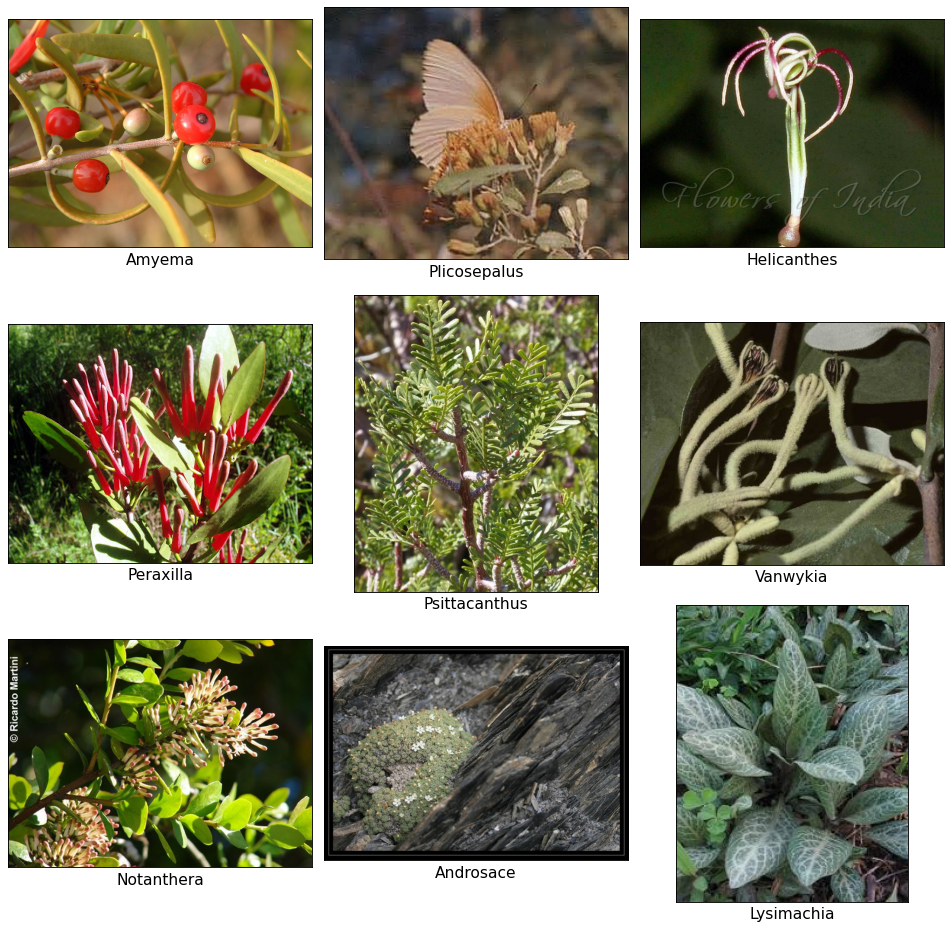

In [8]:
# Collect binary image data from DataFrame
df = differences
rows, cols = 3, 3
image_data_list = [row["data"] for row in df.limit(rows * cols).collect()]
binomial_names = [row["genus"] for row in df.limit(rows * cols).collect()]

# Display the images in a grid with binomial names
display_images_from_binary(image_data_list, binomial_names, grid_size=(3, 3))